In [1]:
import getpass
user_id = getpass.getuser()

import sys
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *


import os
import pandas as pd
from statistics import median, stdev
import seaborn as sns

In [2]:

def ratios_for_metrics(group_name, group_2, group_1, eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    score_dir = mimic_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"{group_name}_{group_2}2{group_1}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


In [3]:

def stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT or DeepJDOT
    """
    metric_stats = []
    score_dir = None
    if group_name == 'insurance':
        score_dir = mimic_output_dir
    elif group_name == 'version':
        score_dir = cross_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"{group_name}_{group_2}_to_{group_1}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=None)

        # get target metric
        metric_stats.append(get_target_stats(score_df, eval_metric, trans_metric, log=True, filter_na=filter_na))

    return np.array(metric_stats)

In [4]:
def print_median_std(ratios, trans_metrics, eval_metric):
    """ 
    Get median and standard deviation for the ratios of trans_metrics ('OT', 'TCA', 'MMD')
    """
    for i, trans_metric in enumerate(trans_metrics):
        print(f'{eval_metric} for {trans_metric}, Median: {median(ratios[i]):.1%}, Stdev: {stdev(ratios[i]):.1%}')

In [5]:
# score_dir = f"/home/{user_id}/OTTEHR/outputs/mimic_iii/"

# eval_metric = 'MAE'
eval_metric = 'RMSE'

# group_name = 'insurance'
# groups = ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid']

# group_name = 'marital_status'
# groups = ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']

score_dir = f"/home/{user_id}/OTTEHR/outputs/cross/"
group_name = 'version'
groups = ['mimic_iii', 'mimic_iv']



In [6]:
def print_latex(source, target, stats, filter_na = True):
    """ 
    Print latex for ratios
    """
    if source == 'Self_Pay':
        source = 'Self\_Pay'
    if target == 'Self_Pay':
        target = 'Self\_Pay'
    print_str = f"{source.title()} & {target.title()}"

    for stat in stats:
        if filter_na:
            stat = [x for x in stat if not pd.isna(x)]
        print_str += f' & {median(stat):.2f}({stdev(stat):.2f})'
    print_str += ' \\\ \hline'
    print(print_str)
    

 & 13.90(0.30) & 13.94(0.29) & 14.01(0.24) & 14.01(0.24) & 14.05(0.23) \\ \hline


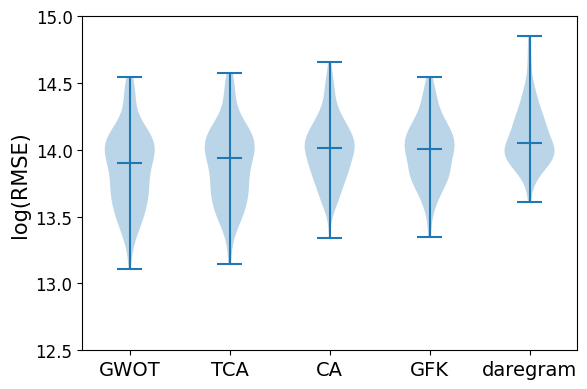

In [12]:
# Present the overall performance for OTTEHR, TCA, CA and GFK
# Include this in the main manuscript

trans_metrics = ['OT', 'TCA', 'CA', 'GFK','RSD','daregram']
if group_name == 'version':
    trans_metrics = ['GWOT', 'TCA', 'CA', 'GFK','daregram']
trans_metric_labels = []
for metric in trans_metrics:
    if metric == 'OT':
        trans_metric_labels.append('OTTEHR')
    else:
        trans_metric_labels.append(metric)

stats_combined = None

for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue
        if group_name == 'version' and group_1 != 'mimic_iv' and group_2 != 'mimic_iii':
            continue        
        stats = stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na=False)
        if stats_combined is None:
            stats_combined = stats
        else:
            stats_combined = np.concatenate((stats_combined, stats), axis=1)

# Print population median and standard deviation
print_str = ""
for i, trans_metric in enumerate(trans_metrics):
    if trans_metric == 'RSD': # filter out na for RSD
        filtered_RSD_results = [x for x in stats_combined[i] if not pd.isna(x)]
        print_str += f' & {median(filtered_RSD_results):.2f}({stdev(filtered_RSD_results):.2f})'
    else:
        print_str += f' & {median(stats_combined[i]):.2f}({stdev(stats_combined[i]):.2f})'
print_str += ' \\\ \hline'

print(print_str)

# Plot the dataframe
plt.figure(figsize=[6, 4])

# plt.violinplot([stats_combined[0], stats_combined[1], stats_combined[2], stats_combined[3], filtered_RSD_results, stats_combined[5]], showmedians=True)
plt.violinplot([stats_combined[0], stats_combined[1], stats_combined[2], stats_combined[3], stats_combined[4]], showmedians=True)

plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metric_labels)
plt.ylabel(f"log({eval_metric})", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_xticklabels(labels=trans_metric_labels, fontsize=14)
plt.ylim(12.5, 15)
fig_path = os.path.join(mimic_output_dir, f"{group_name}_{eval_metric}.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

 & 13.90(0.30) & 13.94(0.29) & 14.01(0.24) & 14.01(0.24) & 14.05(0.23) \\ \hline


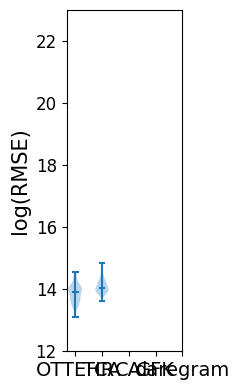

In [14]:
# Present the overall performance for OTTEHR and deepJDOT
# Include this in the main manuscript

trans_metric_labels = []
for metric in trans_metrics:
    if metric == 'OT' or metric == 'GWOT':
        trans_metric_labels.append('OTTEHR')
    else:
        trans_metric_labels.append(metric)

stats_combined = None

for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue  
        if group_name == 'version' and group_1 != 'mimic_iv' and group_2 != 'mimic_iii':
            continue       
        stats = stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na=False)
        if stats_combined is None:
            stats_combined = stats
        else:
            stats_combined = np.concatenate((stats_combined, stats), axis=1)
        


filtered_deepJDOT_results = None

# Print population median and standard deviation
print_str = ""
for i, stats in enumerate(stats_combined):
    if i == len(stats_combined)-1:
        filtered_deepJDOT_results = [x for x in stats_combined[i] if not pd.isna(x)]
        print_str += f' & {median(filtered_deepJDOT_results):.2f}({stdev(filtered_deepJDOT_results):.2f})'
    else:
        print_str += f' & {median(stats):.2f}({stdev(stats):.2f})'
print_str += ' \\\ \hline'

print(print_str)

# Plot the dataframe
plt.figure(figsize=[2.5, 4])

plt.violinplot([stats_combined[0], filtered_deepJDOT_results], showmedians=True)

plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metric_labels)
plt.ylabel(f"log({eval_metric})", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_xticklabels(labels=trans_metric_labels, fontsize=14)
plt.ylim(12, 23)
fig_path = os.path.join(mimic_output_dir, f"{group_name}_{eval_metric}_deepJDOT.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [ ]:
# Calculate the pairwise performance for OTTEHR, TCA, CA, GFK and deepJDOT
# Include this in the supplementary materials 

trans_metrics = ['OT', 'TCA', 'CA', 'GFK', 'deepJDOT', 'RSD', 'daregram']

stats_combined = None
for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue        
        stats = stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na=False)
        if stats_combined is None:
            stats_combined = stats
        else:
            stats_combined = np.concatenate((stats_combined, stats), axis=1)

        print_latex(group_1, group_2, stats)

# Print population median and standard deviation
print_str = "\multicolumn{2}{|c|}{Population Median}"
for i, trans_metric in enumerate(trans_metrics):
    if trans_metric == 'deepJDOT' or trans_metric == 'RSD':
        filtered_results = [x for x in stats_combined[i] if not pd.isna(x)]
        print_str += f' & {median(filtered_results):.2f}({stdev(filtered_results):.2f})'
    else:
        print_str += f' & {median(stats_combined[i]):.2f}({stdev(stats_combined[i]):.2f})'
print_str += ' \\\ \hline'
print(print_str)

Separated & Divorced & 13.81(0.26) & 14.00(0.25) & 14.05(0.23) & 14.01(0.24) & 13.64(0.25) & 14.06(0.25) & 14.02(0.20) \\ \hline
Separated & Married & 13.83(0.24) & 14.01(0.21) & 14.07(0.20) & 14.01(0.22) & 13.63(0.36) & 13.97(0.17) & 13.99(0.17) \\ \hline
Separated & Widowed & 13.77(0.24) & 14.00(0.21) & 14.03(0.21) & 14.01(0.21) & 13.52(0.19) & 13.89(0.16) & 13.89(0.16) \\ \hline
Separated & Single & 13.88(0.21) & 14.07(0.18) & 14.10(0.19) & 14.07(0.18) & 13.78(0.23) & 14.06(0.18) & 14.04(0.21) \\ \hline
Divorced & Separated & 13.85(0.24) & 13.97(0.21) & 14.01(0.21) & 13.97(0.21) & 13.91(0.51) & 14.10(0.17) & 14.17(0.18) \\ \hline
Divorced & Married & 13.75(0.21) & 13.89(0.25) & 13.93(0.24) & 13.88(0.24) & 13.64(0.31) & 14.01(0.17) & 13.99(0.18) \\ \hline
Divorced & Widowed & 13.66(0.27) & 13.86(0.29) & 13.87(0.28) & 13.85(0.29) & 13.47(0.91) & 13.92(0.16) & 13.89(0.16) \\ \hline
Divorced & Single & 13.83(0.22) & 13.94(0.27) & 13.97(0.25) & 13.92(0.26) & 13.70(1.17) & 14.07(0.17) & 1